In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import imutils
import easyocr
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
#!pip install easyocr
#!pip install imutils

Image opening

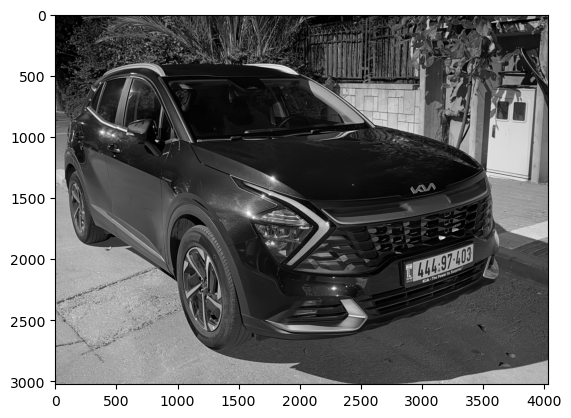

In [3]:
img = cv2.imread("E:\Programs\study\HIT\Third year\CarNumbersProject\Car_Numbers\TrainData\IMG_4148.JPG")
#img = cv2.imread(r"E:\Programs\study\HIT\Third year\CarNumbersProject\Car_Numbers\TestData\IMG_4057.JPG")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

Filtering

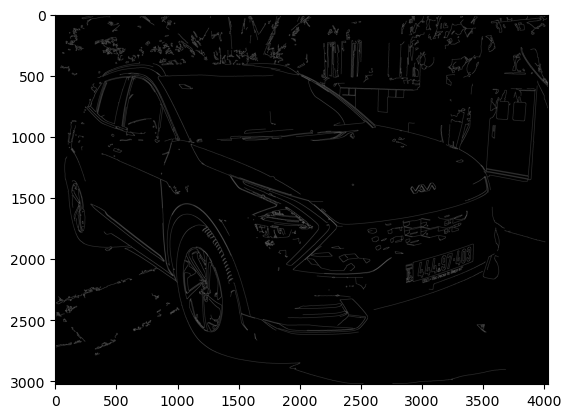

In [4]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 20, 400) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [5]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [6]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
    if len(approx) == 4:
        location = approx
        break

In [7]:
print(location)

[[[3421 1880]]

 [[2929 2029]]

 [[2928 2185]]

 [[3414 2023]]]


In [8]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

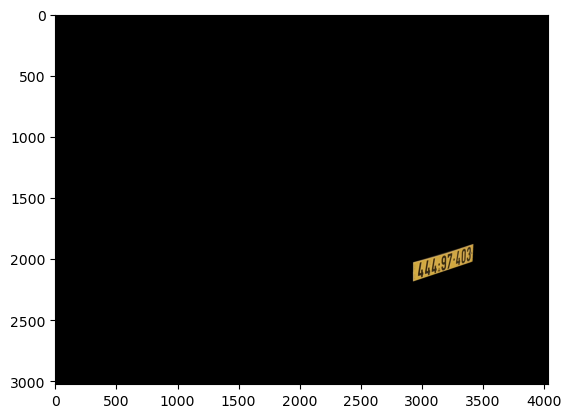

In [9]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [10]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

Car number plate

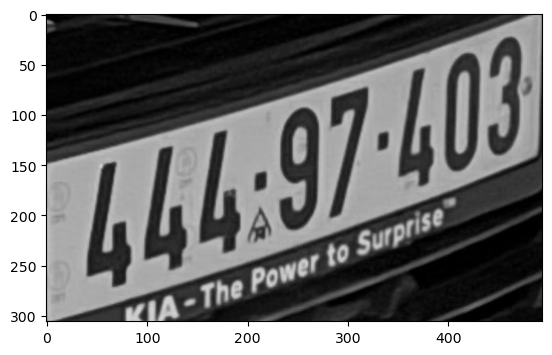

In [11]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [12]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[276, 224], [308, 224], [308, 256], [276, 256]], 't0', 0.9455239140329001),
 ([[72, 258], [204, 258], [204, 306], [72, 306]],
  'Ia - The',
  0.04975699573921327),
 ([[0.42420388312545043, 142.57566893118855],
   [488.95183298589086, 0.6782257150117896],
   [521.5757961168746, 154.42433106881145],
   [32.048167014109126, 296.32177428498824]],
  '444;97.403',
  0.5179536386176028),
 ([[296.01985123916006, 216.601985123916],
   [400.2220841042933, 182.62973123362335],
   [410.98014876083994, 218.398014876084],
   [306.7779158957067, 251.37026876637665]],
  'Surprise',
  0.9983876394859479),
 ([[193.67504722512362, 248.74506611517307],
   [277.2704225575725, 231.69688552283628],
   [284.3249527748764, 269.2549338848269],
   [199.7295774424275, 286.3031144771637]],
  'Power',
  0.9893845041646611)]

In [13]:
detected_text = result[2][1]
print(detected_text)

444;97.403


Final Car Number

In [14]:
import re
numeric_part = re.sub(r'\D', '', detected_text)
print(numeric_part)

44497403


Car number database

In [15]:
from datetime import datetime, timedelta

mock_database = {
    "1234567": {
        "name": "John Doe", 
        "phone": "123-456-7890", 
        "parking_time": "2024-11-07 15:40:00"
    },
    "7654321": {
        "name": "Jane Smith", 
        "phone": "987-654-3210", 
        "parking_time": "2024-11-07 14:35:00"
    },
    "44497403": {
        "name": "Alice Johnson", 
        "phone": "456-123-7890", 
        "parking_time": "2024-11-07 10:15:00"
    },
    "5566778": {
        "name": "Bob Brown", 
        "phone": "321-987-6540", 
        "parking_time": "2024-11-07 10:38:00"
    }
}

In [16]:
if numeric_part in mock_database:
    owner_info = mock_database[numeric_part]
    print(f"Car Number: {numeric_part}")
    print(f"Owner Name: {owner_info['name']}")
    print(f"Phone Number: {owner_info['phone']}")
    print(f"Parking Time: {owner_info['parking_time']}")
else:
    print("Car number not found in the database.")

Car Number: 44497403
Owner Name: Alice Johnson
Phone Number: 456-123-7890
Parking Time: 2024-11-07 10:15:00


In [17]:
#Parking time

parking_time =  owner_info['parking_time']
parking_time = datetime.strptime(parking_time, "%Y-%m-%d %H:%M:%S")
print(parking_time)

2024-11-07 10:15:00


In [18]:
#current_time = datetime.now()  here we can get real time if needed 

#Current Time

current_time = "2024-11-07 16:10:00"
current_time = datetime.strptime(current_time, "%Y-%m-%d %H:%M:%S") #neded for manual time adding 
print(current_time)

2024-11-07 16:10:00


In [19]:
#Time difference between entrance time parking and exiting

time_difference = current_time - parking_time 

In [20]:
print(f"Time parked: {time_difference}")
print(f"Time parked (in minutes): {time_difference.total_seconds() / 60:.2f} minutes")

Time parked: 5:55:00
Time parked (in minutes): 355.00 minutes


In [21]:
total_minutes = time_difference.total_seconds() / 60
fractional_hour = total_minutes / 60
print(f"Time as fraction of an hour: {fractional_hour:.2f}")


Time as fraction of an hour: 5.92


In [22]:
#Here we know for how many hours we need to pay, we assume that we can't pay in quaters or halfs 

def process_number(num):
    if num % 1 != 0:
        return 1
    else:
        return 0
    
fractional_hour = fractional_hour + process_number(fractional_hour)
fractional_hour = int(fractional_hour)
print(fractional_hour)

6


Example Code database

In [23]:
Buyed_in_special_shop = False

#Bill code examples - database needed
list = (12345,45678,21451,12358,87945) #used for database example only 

#Examples:
Bill_code = 12345    #database needed  --> manual entering, in real situation we will check our number with database
points = 100         #database needed  --> same 


 We assume that we use points only for parking, it can be changed if needed

In [24]:
#we assuame that 1 bill can give 100 points ,can be changed if needed 

if Bill_code in list:
    points = points + 100
    Buyed_in_special_shop = True

In [25]:
def get_answer(points):
    while True:
        num = int(input("Enter an integer: ")) 
        if num == 1 or num == 2:
            extra_hours = check_extra_hours(fractional_hour)  # extra parking hours
            hours = check_hours(points)   
            if num == 1:
                if hours < extra_hours:
                    print('You paid', extra_hours - hours, 'hours by points')
                    extra_hours = extra_hours - hours
                    points = 0
                    return False, extra_hours, points
                    
                elif hours == extra_hours:
                    print("Your parking paid successfully")
                    extra_hours = 0
                    points = 0
                    return True, extra_hours, points
                    
                else:  # extra_hours > hours
                    print("Your parking paid successfully and you still have points for next parking")
                    hours = hours - extra_hours
                    extra_hours = 0
                    points = hours*100
                    return True, extra_hours, points
            else:
                
                return False, extra_hours, points
                
        else:
            print("Try again")

def check_hours(points):
    return points / 100  

def check_extra_hours(hours):
    return hours - 3  


while True:
    if fractional_hour < 3:
        print('Free parking')
        break
    elif fractional_hour > 3 and Buyed_in_special_shop:
        print('You can use points or you can pay for parking')
        print('Please choose:')
        print(' 1-Yes \n 2-No ')
        
        free_to_go, extra_hours, hours = get_answer(points) 
        
        #Here we save pionts to database for next parking 
        
        if free_to_go:
            break
        else:
            Buyed_in_special_shop = False  
    else:
        print("You need to pay extra", extra_hours, "hours")
        break


You can use points or you can pay for parking
Please choose:
 1-Yes 
 2-No 
Enter an integer: 1
You paid 1.0 hours by points
You need to pay extra 1.0 hours
